## NGDS-Projekt - Gruppe J

Namen und E-Mail-Adressen der Gruppenmitglieder:

- Melanie Rohrbacher, <rohrbme1@students.zhaw.ch> 
- (Adriana Grabar, <grabaadr@students.zhaw.ch> --> leider aus dem Studium ausgetreten, siehe Mail vom Mi, 23.04.24)

Zugeteilte Wetterstation:  SCU

### Bibliotheken importieren und globaler Parameter definieren

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.signal import convolve

### 1. Daten importieren und bereinigen

Importiert die Daten (Strings und Zahlen getrennt), wählt die relevanten Spalten und Zeilen aus und löscht fehlende Werte. Am Ende sollt ihr je ein Array für den Messzeitpunkt (in Tagen seit der ersten Messung) und die gemessenen Wetterdaten für eure Wetterstation haben.

In [83]:
# Daten aus der CSV-Datei laden
data = pd.DataFrame(pd.read_csv("Graubuenden.csv"))


# SCU Wetterstation herausfiltern
scu_data = data[data['stn'] == 'SCU'].copy()  # Kopie des DataFrames erstellt
scu_data.dropna(inplace=True)
scu_data['date_time'] = pd.to_datetime(scu_data['date_time'])
start_date = scu_data['date_time'].min()
scu_data['time_days'] = (scu_data['date_time'] - start_date).dt.total_seconds() / (60 * 60 * 24)

# Auswahl relevanter Spalten
selected_columns = ['stn', 'date_time', 'prestah0', 'tre200h0', 'rre150h0', 'su2000h0', 'time_days']
scu_data = scu_data[selected_columns]

# Reset index
scu_data.reset_index(drop=True, inplace=True)

# Anzahl der Werte für die Wetterstation "SCU" anzeigen
num_values_scu = len(scu_data)
print("Anzahl der Werte für die Wetterstation 'SCU':", num_values_scu)


# Ergebnis anzeigen
print("""
      
      Werte für die Wetterstation 'SCU':""")
scu_data

Anzahl der Werte für die Wetterstation 'SCU': 7453

      
      Werte für die Wetterstation 'SCU':


,stn,date_time,prestah0,tre200h0,rre150h0,su2000h0,time_days
0,SCU,2023-01-01 00:00:00,880.7,0.3,0.0,0.0,0.000000
1,SCU,2023-01-01 01:00:00,880.7,0.3,0.0,0.0,0.041667
2,SCU,2023-01-01 03:00:00,880.7,0.0,0.0,0.0,0.125000
3,SCU,2023-01-01 04:00:00,880.5,0.1,0.0,0.0,0.166667
4,SCU,2023-01-01 08:00:00,881.1,0.1,0.0,0.0,0.333333
...,...,...,...,...,...,...,...
7448,SCU,2023-12-31 19:00:00,861.3,-0.3,1.7,0.0,364.791667
7449,SCU,2023-12-31 20:00:00,862.5,0.0,3.4,0.0,364.833333
7450,SCU,2023-12-31 21:00:00,862.8,0.0,4.0,0.0,364.875000
7451,SCU,2023-12-31 22:00:00,863.1,-0.4,1.6,0.0,364.916667


### 2. Interpolation

Wir haben 15% der Zeilen in den Originaldaten gelöscht. Also gibt es nicht genau stündlich Messwerte.

Bestimmt eine Interpolationsfunktion für jede Messgrösse und interpoliert die Messreihen viertelstündlich (d.h. für jede Stunde vier Werte plus den Endpunkt am 1. Januar um 0:00).

Wählt die Art und den Grad der Interpolation so aus, dass die interpolierten Werte auch physikalisch sinnvoll sind.

In [84]:
# Alle 15 Minuten einen neuen DataFrame erstellen mit einem Datum/Uhrzeit-Index
interpolation_index = pd.date_range(start=scu_data['date_time'].min(), end=scu_data['date_time'].max(), freq='15T')
interpolated_data = pd.DataFrame(index=interpolation_index)

# Durchführen jeder Messvariable mit einer kubischen Interpolation 
for column in ['prestah0', 'tre200h0', 'rre150h0', 'su2000h0']:
    interp_func = interp1d(scu_data['date_time'].astype(np.int64), scu_data[column], kind='cubic', fill_value='extrapolate')
    interpolated_data[column] = interp_func(interpolation_index.astype(np.int64))

# Interpolate temperature data
interpolation_index = pd.date_range(start=scu_data['date_time'].min(), end=scu_data['date_time'].max(), freq='15T')
interp_func = interp1d(scu_data['date_time'].astype(np.int64), scu_data['tre200h0'], kind='cubic', fill_value='extrapolate')
interpolated_temps = interp_func(interpolation_index.astype(np.int64))

# Interpolate air pressure data
interpolation_index = pd.date_range(start=scu_data['date_time'].min(), end=scu_data['date_time'].max(), freq='15T')
interp_func = interp1d(scu_data['date_time'].astype(np.int64), scu_data['prestah0'], kind='cubic', fill_value='extrapolate')
interpolated_pressures = interp_func(interpolation_index.astype(np.int64))

# Interpolate precipitation data
interpolation_index = pd.date_range(start=scu_data['date_time'].min(), end=scu_data['date_time'].max(), freq='15T')
interp_func = interp1d(scu_data['date_time'].astype(np.int64), scu_data['rre150h0'], kind='cubic', fill_value='extrapolate')
interpolated_precipitations = interp_func(interpolation_index.astype(np.int64))

# Interpolate sunshine duration data
interpolation_index = pd.date_range(start=scu_data['date_time'].min(), end=scu_data['date_time'].max(), freq='15T')
interp_func = interp1d(scu_data['date_time'].astype(np.int64), scu_data['su2000h0'], kind='cubic', fill_value='extrapolate')
interpolated_sunshine_durations = interp_func(interpolation_index.astype(np.int64))


# Kopf der interpolierten Daten anzeigen
print('Interpolated data head:')
print(interpolated_data.head())

Interpolated data head:
                       prestah0  tre200h0      rre150h0      su2000h0
2023-01-01 00:00:00  880.700000  0.300000  0.000000e+00  0.000000e+00
2023-01-01 00:15:00  880.685913  0.333156 -2.156305e-30 -7.035773e-04
2023-01-01 00:30:00  880.682924  0.341325 -2.613703e-30 -8.528209e-04
2023-01-01 00:45:00  880.688474  0.328832 -1.764249e-30 -5.756541e-04
2023-01-01 01:00:00  880.700000  0.300000  0.000000e+00  1.084202e-19


### 3. Daten und Interpolation darstellen und vergleichen 

Um die Interpolation zu überprüfen, stellt für alle Variablen jeweils die Daten und die Interpolationsfunktion zusammen grafisch dar.

Wählt dazu ein Zeitfenster von ein paar Tagen, in dem alle Variablen ein etwas interessantes Verhalten zeigen, d.h. es fällt Regen und die Sonne scheint.

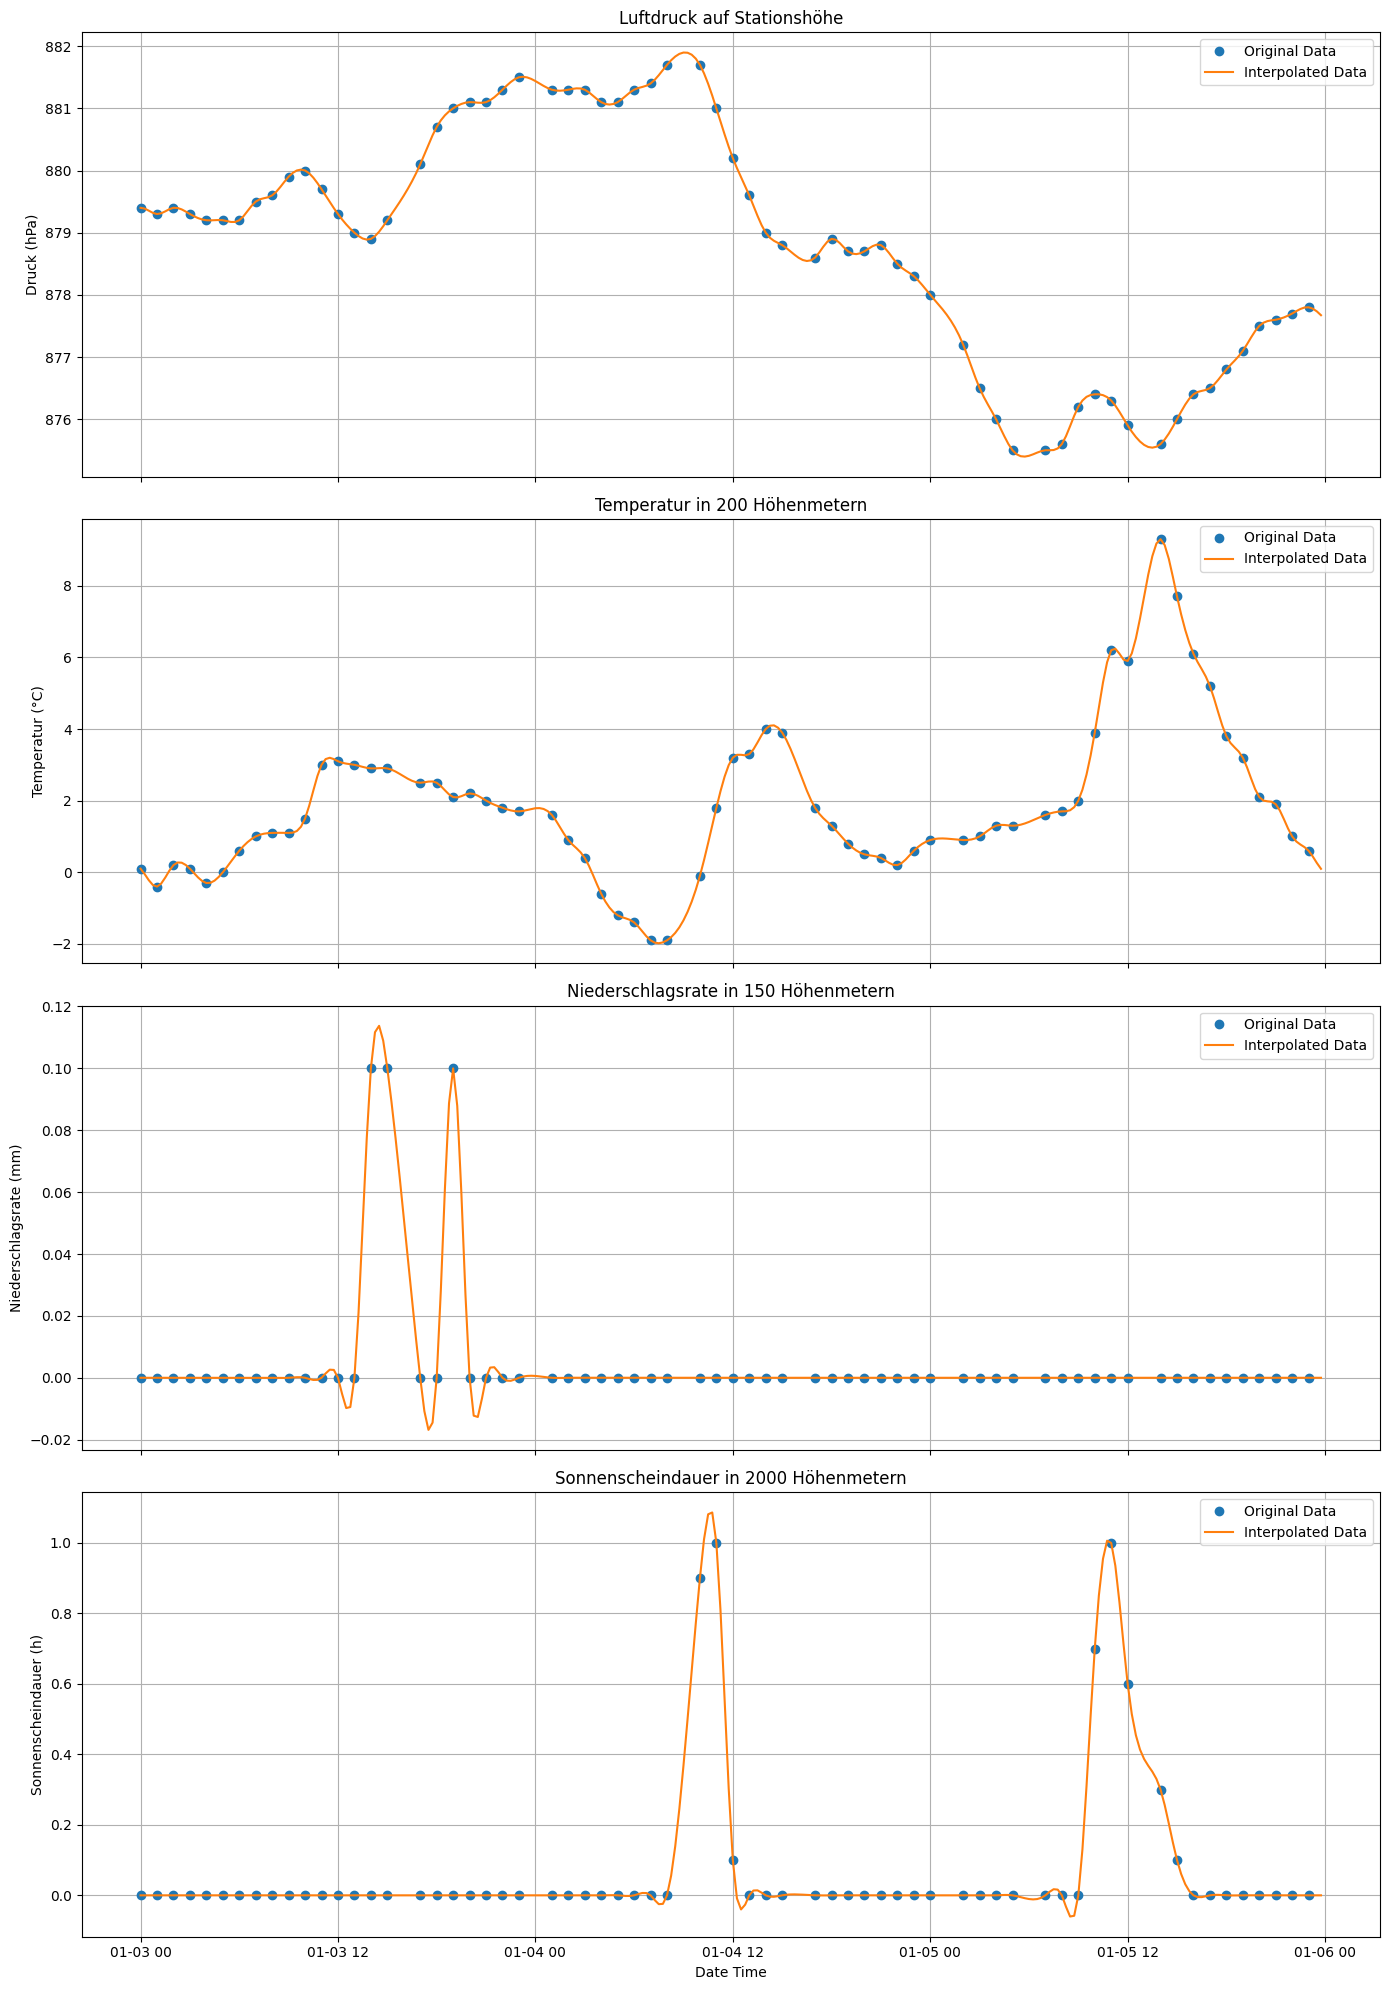

In [85]:
start_window = '2023-01-03 00:00:00'
end_window = '2023-01-05 23:59:59'

# Filter the original and interpolated data for this time window
original_window = scu_data[(scu_data['date_time'] >= start_window) & (scu_data['date_time'] <= end_window)]
interpolated_window = interpolated_data.loc[start_window:end_window]

# Create subplots for each variable to compare original and interpolated data
fig, axs = plt.subplots(4, 1, figsize=(14, 20), sharex=True, facecolor='white')
variables = ['prestah0', 'tre200h0', 'rre150h0', 'su2000h0']
titles = [
    'Luftdruck auf Stationshöhe', 
    'Temperatur in 200 Höhenmetern', 
    'Niederschlagsrate in 150 Höhenmetern', 
    'Sonnenscheindauer in 2000 Höhenmetern'
]
y_labels = ['Druck (hPa)', 'Temperatur (°C)', 'Niederschlagsrate (mm)', 'Sonnenscheindauer (h)']

for i, var in enumerate(variables):
    axs[i].plot(original_window['date_time'], original_window[var], 'o', label='Original Data')
    axs[i].plot(interpolated_window.index, interpolated_window[var], label='Interpolated Data')
    axs[i].set_title(titles[i])
    axs[i].set_ylabel(y_labels[i])
    axs[i].grid(True)
    axs[i].legend()

# Set common labels
plt.xlabel('Date Time')
plt.tight_layout()

# Show the plot
plt.show()

Hier sind die Diagramme, die einen Vergleich zwischen den Original- und interpolierten Daten für jede Variable innerhalb des ausgewählten Zeitfensters vom 3. bis 5. Januar 2023 zeigen.

### 4. Nullstellen der Temperatur bestimmen

Wählt einen von ca. einer Woche, in der die Temperatur um Null herum schwankt. 

Bestimmt die Zeitpunkte, an denen die Temperatur den Wert Null hat. Nutzt dazu die Interpolationsfunktion der Temperatur aus Schritt 2.

Stellt die Temperatur und die Nullstellen zusammen grafisch dar.

Alternativ (und ein wenig schwieriger) könnt ihr auch einen Zeitraum wählen, in der die Temperatur hohe Werte erreicht. Bestimmt dann die Zeitpunkte, an denen die Temperatur einen bestimmten Hitzewert überschreitet, z.B. 30 Grad.

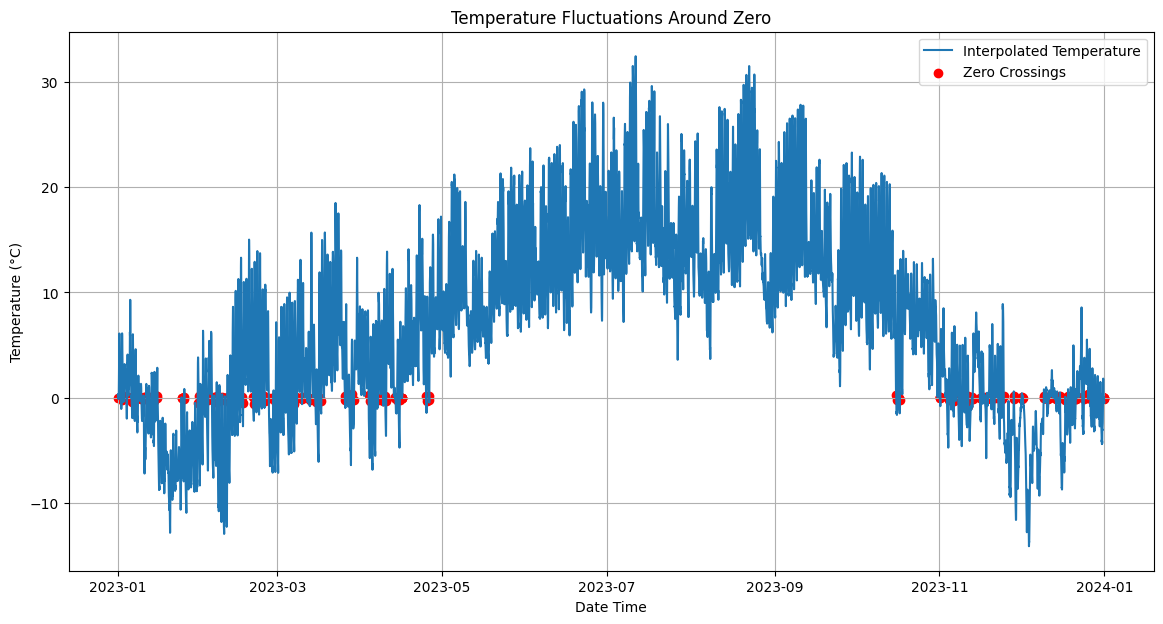

Zero crossing times:
DatetimeIndex(['2023-01-01 05:15:00', '2023-01-01 07:30:00',
               '2023-01-02 04:15:00', '2023-01-02 09:15:00',
               '2023-01-03 00:00:00', '2023-01-03 01:30:00',
               '2023-01-03 03:00:00', '2023-01-03 05:00:00',
               '2023-01-04 03:15:00', '2023-01-04 10:00:00',
               ...
               '2023-12-29 09:30:00', '2023-12-29 17:30:00',
               '2023-12-30 10:45:00', '2023-12-30 17:15:00',
               '2023-12-31 12:00:00', '2023-12-31 16:30:00',
               '2023-12-31 17:45:00', '2023-12-31 18:00:00',
               '2023-12-31 19:45:00', '2023-12-31 21:00:00'],
              dtype='datetime64[ns]', length=265, freq=None)


In [86]:
# Interpolate temperature data
interp_func = interp1d(scu_data['date_time'].astype(np.int64), scu_data['tre200h0'], kind='cubic', fill_value='extrapolate')
interpolation_index = pd.date_range(start=scu_data['date_time'].min(), end=scu_data['date_time'].max(), freq='15T')
interpolated_temps = interp_func(interpolation_index.astype(np.int64))

# Find zero crossings
zero_crossings = np.where(np.diff(np.signbit(interpolated_temps)))[0]
zero_crossing_times = interpolation_index[zero_crossings]

# Plot temperature and zero crossings
plt.figure(figsize=(14, 7), facecolor='white')
plt.plot(interpolation_index, interpolated_temps, label='Interpolated Temperature')
plt.scatter(zero_crossing_times, interpolated_temps[zero_crossings], color='red', label='Zero Crossings')
plt.title('Temperature Fluctuations Around Zero')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Output zero crossing times
print('Zero crossing times:')
print(zero_crossing_times)

### 5. Grosse Schwankungen in Temperatur oder Luftdruck finden

Betrachtet entweder die Temperatur oder den Luftdruck übers ganze Jahr. Berechnet die Ableitung der gewählten Variable und stellt diese auch dar, um einen Zeitraum von ca. 1 Woche mit grossen Schwankungen zu finden.

In der gewählten Woche mit grossen Schwankungen sollen nun die Zeitpunkte bestimmt werden, zu denen die Temperatur bzw. der Luftdruck am stärksten steigt bzw. fällt, also das Maximum und das Minimum der Ableitung.

Um das Maximum/Minimum eines Arrays zu finden, könnt ihr die Funktionen [`np.argmax`](https://numpy.org/doc/stable//reference/generated/numpy.argmax.htm) und [`np.argmin`](https://numpy.org/doc/stable//reference/generated/numpy.argmin.html) verwenden. 

 #### Temperaturschwankungen:

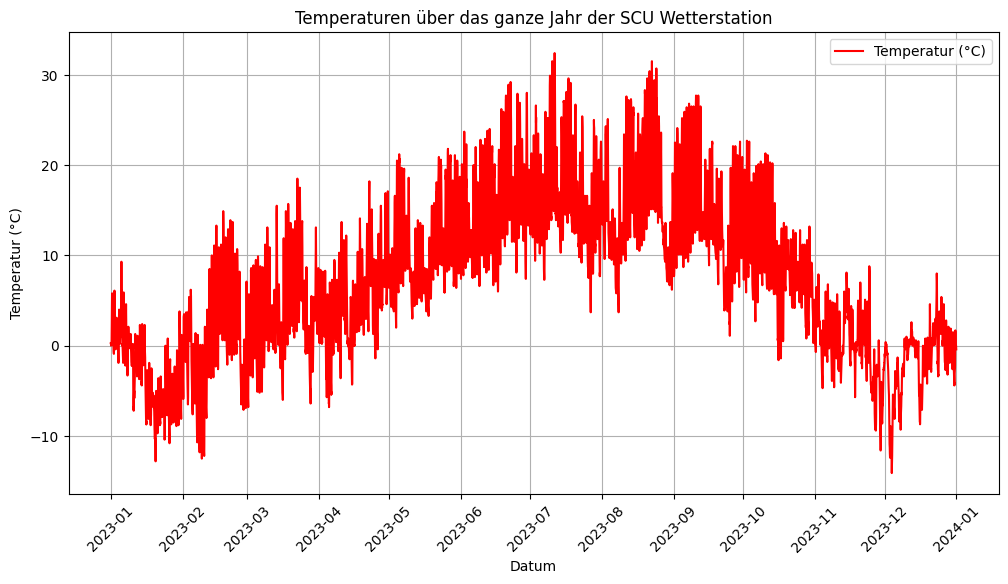

In [87]:
# Grafik für die Temperaturen über das ganze Jahr
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(scu_data['date_time'], scu_data['tre200h0'], label='Temperatur (°C)', color='red')
plt.title('Temperaturen über das ganze Jahr der SCU Wetterstation')
plt.xlabel('Datum')
plt.ylabel('Temperatur (°C)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Woche der maximalen Fluktuation beginnt: 2023-06-29 11:00:00
Maximaler Ableitungspunkt: date_time          2023-07-03 07:00:00
temp_derivative                   61.2
Name: 3752, dtype: object
Minimaler Ableitungspunkt date_time          2023-06-29 19:00:00
temp_derivative                 -106.8
Name: 3680, dtype: object


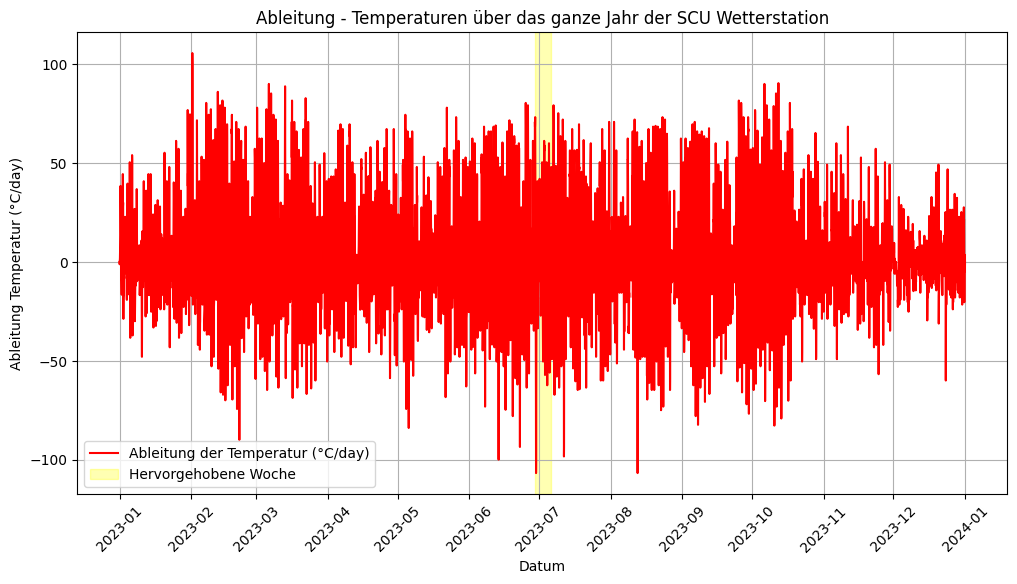

In [88]:
# Ableitung der Temperatur berechnen
scu_data['temp_derivative'] = np.gradient(scu_data['tre200h0'], scu_data['time_days'])

# Woche mit den grössten Schwankungen
# Berechnung absoluten Werte der Temperaturableitung, um sowohl positive als auch negative Änderungen zu berücksichtigen
derivative_abs = scu_data['temp_derivative'].abs()

# Summe absoluter Ableitungen über ein 7-Tage-Fenster, um die Woche mit der höchsten Gesamtveränderung zu finden
scu_data['rolling_derivative_sum'] = derivative_abs.rolling(window=7).sum()

# Identifizierung Startdatum der Woche mit der maximalen Summe absoluter Ableitungen
max_fluctuation_start_date = scu_data.loc[scu_data['rolling_derivative_sum'].idxmax(), 'date_time']

# Daten dieser Woche filtern
week_of_max_fluctuation = scu_data[(scu_data['date_time'] >= max_fluctuation_start_date) & (scu_data['date_time'] < max_fluctuation_start_date + pd.Timedelta(days=7))]

# Punkte der maximalen und minimalen Ableitung innerhalb dieser Woche
max_derivative_idx = week_of_max_fluctuation['temp_derivative'].idxmax()
min_derivative_idx = week_of_max_fluctuation['temp_derivative'].idxmin()

max_derivative_point = week_of_max_fluctuation.loc[max_derivative_idx, ['date_time', 'temp_derivative']]
min_derivative_point = week_of_max_fluctuation.loc[min_derivative_idx, ['date_time', 'temp_derivative']]

print('Woche der maximalen Fluktuation beginnt:', max_fluctuation_start_date)
print('Maximaler Ableitungspunkt:', max_derivative_point)
print('Minimaler Ableitungspunkt', min_derivative_point)

# Grafik darstellen
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(scu_data['date_time'], scu_data['temp_derivative'], label='Ableitung der Temperatur (°C/day)', color='red')
plt.axvspan(max_fluctuation_start_date, max_fluctuation_start_date + pd.Timedelta(days=7), color='yellow', alpha=0.3, label='Hervorgehobene Woche')
plt.title('Ableitung - Temperaturen über das ganze Jahr der SCU Wetterstation')
plt.xlabel('Datum')
plt.ylabel('Ableitung Temperatur (°C/day)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Angepasster Index der maximalen Temperaturableitung:: 3752
Angepasster Index der minimaler Temperaturableitung:: 3680


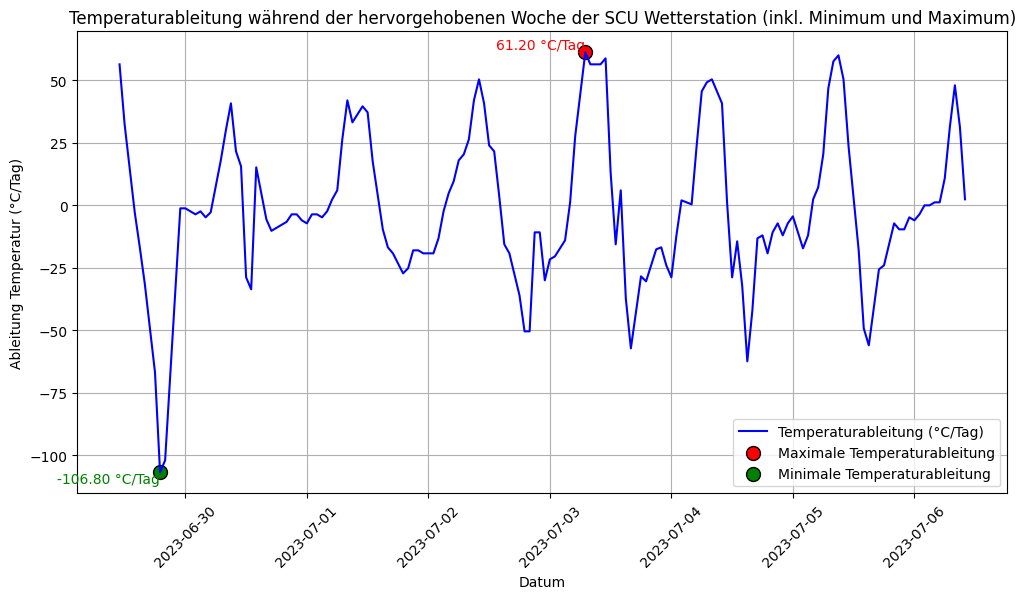

In [89]:
# Berechnen der Indizes für maximale und minimale Temperaturableitungen innerhalb der Teilmenge „week_of_max_fluctuation“ neu
max_derivative_idx = week_of_max_fluctuation['temp_derivative'].idxmax()
min_derivative_idx = week_of_max_fluctuation['temp_derivative'].idxmin()

print('Angepasster Index der maximalen Temperaturableitung::', max_derivative_idx)
print('Angepasster Index der minimaler Temperaturableitung::', min_derivative_idx)

# Grafik für die Temperaturableitung während der hervorgehobenen Woche mit korrigierten Indizes für maximale und minimale Punkte
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(week_of_max_fluctuation['date_time'], week_of_max_fluctuation['temp_derivative'], label='Temperaturableitung (°C/Tag)', color='blue')

# Markierung der Punkte mit maximalem und minimalem Temperaturableitung
plt.scatter(week_of_max_fluctuation.loc[max_derivative_idx, 'date_time'], week_of_max_fluctuation.loc[max_derivative_idx, 'temp_derivative'], color='red', s=100, edgecolors='black', label='Maximale Temperaturableitung')
plt.scatter(week_of_max_fluctuation.loc[min_derivative_idx, 'date_time'], week_of_max_fluctuation.loc[min_derivative_idx, 'temp_derivative'], color='green', s=100, edgecolors='black', label='Minimale Temperaturableitung')

# Hinzufügen von Textbeschriftungen für die maximale und minimale Punktzahl
plt.text(week_of_max_fluctuation.loc[max_derivative_idx, 'date_time'], week_of_max_fluctuation.loc[max_derivative_idx, 'temp_derivative'], f'{week_of_max_fluctuation.loc[max_derivative_idx, "temp_derivative"]:.2f} °C/Tag', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(week_of_max_fluctuation.loc[min_derivative_idx, 'date_time'], week_of_max_fluctuation.loc[min_derivative_idx, 'temp_derivative'], f'{week_of_max_fluctuation.loc[min_derivative_idx, "temp_derivative"]:.2f} °C/Tag', color='green', verticalalignment='top', horizontalalignment='right')


plt.title('Temperaturableitung während der hervorgehobenen Woche der SCU Wetterstation (inkl. Minimum und Maximum)')
plt.xlabel('Datum')
plt.ylabel('Ableitung Temperatur (°C/Tag)')
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

 #### Luftdruckschwankungen:

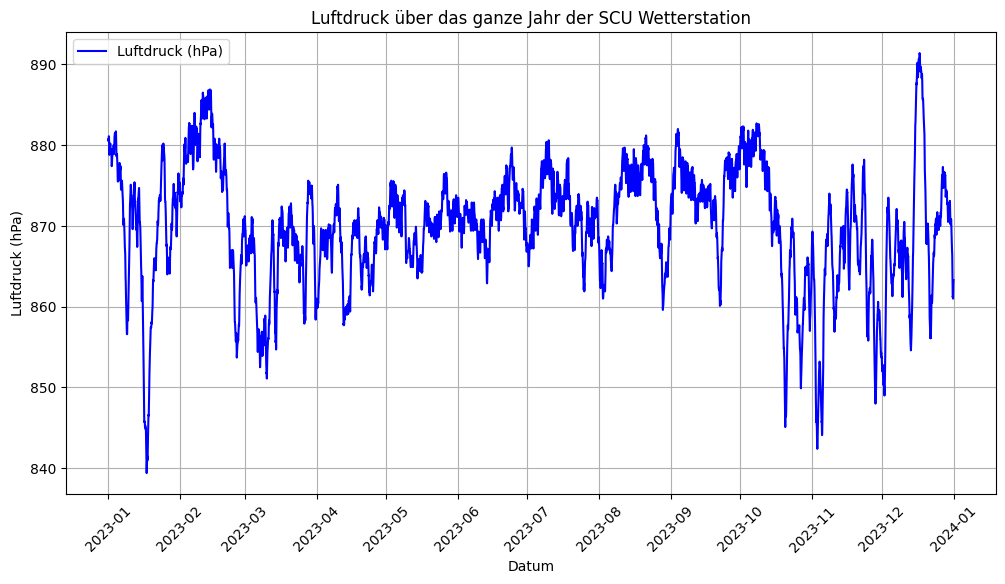

In [90]:
# Grafik für den Luftdruck über das ganze Jahr
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(scu_data['date_time'], scu_data['prestah0'], label='Luftdruck (hPa)', color='blue')
plt.title('Luftdruck über das ganze Jahr der SCU Wetterstation')
plt.xlabel('Datum')
plt.ylabel('Luftdruck (hPa)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

Ableitungspunkt des maximalen Luftdrucks: date_time              2023-06-29 19:00:00
pressure_derivative                   30.0
Name: 3680, dtype: object
Ableitungspunkt des minimalen Luftdrucks: date_time              2023-07-05 10:00:00
pressure_derivative                  -19.2
Name: 3798, dtype: object


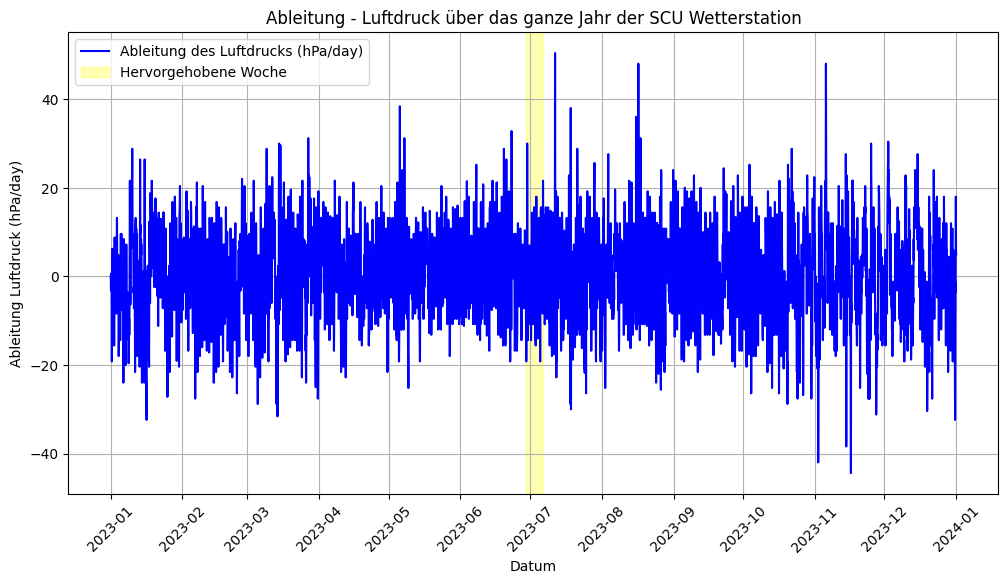

In [91]:
# Ableitung der Luftdruck berechnen
scu_data['pressure_derivative'] = np.gradient(scu_data['prestah0'], scu_data['time_days'])

# Daten für die jeweilige Woche erneut filtieren, um die neue Spalte einzuschliessen
week_of_max_fluctuation = scu_data[(scu_data['date_time'] >= max_fluctuation_start_date) & (scu_data['date_time'] < max_fluctuation_start_date + pd.Timedelta(days=7))]

# Punkte der maximalen und minimalen Ableitung innerhalb dieser Woche für den Luftdruck
max_pressure_derivative_idx = week_of_max_fluctuation['pressure_derivative'].idxmax()
min_pressure_derivative_idx = week_of_max_fluctuation['pressure_derivative'].idxmin()

max_pressure_derivative_point = week_of_max_fluctuation.loc[max_pressure_derivative_idx, ['date_time', 'pressure_derivative']]
min_pressure_derivative_point = week_of_max_fluctuation.loc[min_pressure_derivative_idx, ['date_time', 'pressure_derivative']]

print('Ableitungspunkt des maximalen Luftdrucks:', max_pressure_derivative_point)
print('Ableitungspunkt des minimalen Luftdrucks:', min_pressure_derivative_point)

# Grafik darstellen
plt.figure(figsize=(12, 6), facecolor='white')
plt.plot(scu_data['date_time'], scu_data['pressure_derivative'], label='Ableitung des Luftdrucks (hPa/day)', color='blue')
plt.axvspan(max_fluctuation_start_date, max_fluctuation_start_date + pd.Timedelta(days=7), color='yellow', alpha=0.3, label='Hervorgehobene Woche')
plt.title('Ableitung - Luftdruck über das ganze Jahr der SCU Wetterstation')
plt.xlabel('Datum')
plt.ylabel('Ableitung Luftdruck (hPa/day)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

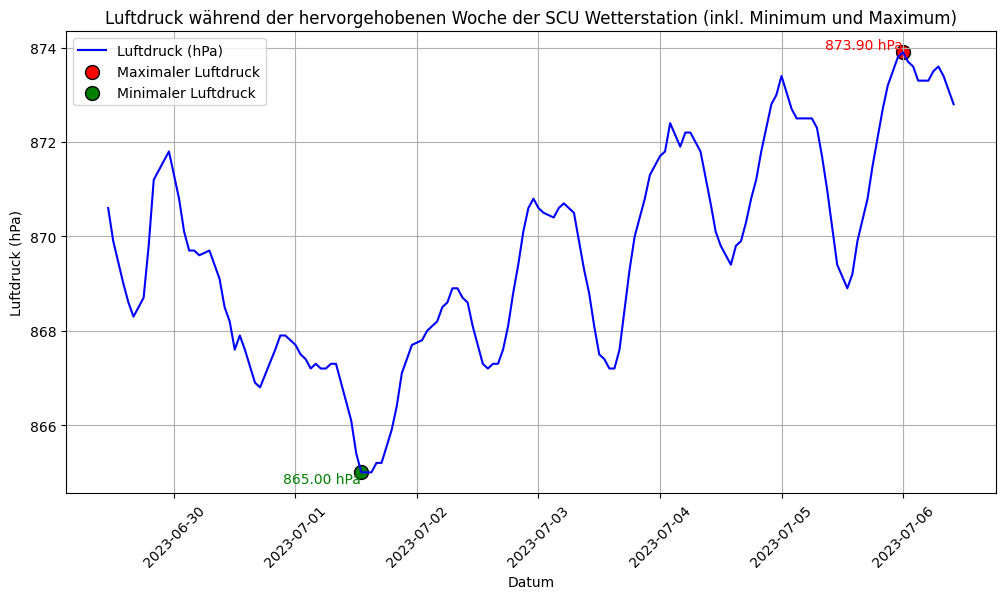

In [92]:
# Grafik für den Luftdruck während der hervorgehobenen Woche mit np.argmax und np.argmin für maximale und minimale Punkte
plt.figure(figsize=(12, 6), facecolor='white')
week_data = scu_data[(scu_data['date_time'] >= max_fluctuation_start_date) & (scu_data['date_time'] < max_fluctuation_start_date + pd.Timedelta(days=7))]
plt.plot(week_data['date_time'], week_data['prestah0'], label='Luftdruck (hPa)', color='blue')

# Berechnung der Indizes für maximale und minimale Luftdruckwerte in der Woche
max_idx = np.argmax(week_data['prestah0'].values)
min_idx = np.argmin(week_data['prestah0'].values)

# Markierung der Punkte mit maximalem und minimalem Luftdruck
plt.scatter(week_data.iloc[max_idx]['date_time'], week_data.iloc[max_idx]['prestah0'], color='red', s=100, edgecolors='black', label='Maximaler Luftdruck')
plt.scatter(week_data.iloc[min_idx]['date_time'], week_data.iloc[min_idx]['prestah0'], color='green', s=100, edgecolors='black', label='Minimaler Luftdruck')

# Hinzufügen von Textbeschriftungen für die maximale und minimale Punktzahl
plt.text(week_data.iloc[max_idx]['date_time'], week_data.iloc[max_idx]['prestah0'], f'{week_data.iloc[max_idx]["prestah0"]:.2f} hPa', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.text(week_data.iloc[min_idx]['date_time'], week_data.iloc[min_idx]['prestah0'], f'{week_data.iloc[min_idx]["prestah0"]:.2f} hPa', color='green', verticalalignment='top', horizontalalignment='right')


plt.title('Luftdruck während der hervorgehobenen Woche der SCU Wetterstation (inkl. Minimum und Maximum)')
plt.xlabel('Datum')
plt.ylabel('Luftdruck (hPa)')
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

### 6. Mittelwerte berechnen

Wählt eine der Messgrössen aus und berechnet den Mittelwert über das ganze Jahr und den Mittelwert pro Monat. Der Einfachheit halber könnt ihr den Monat als 1/12 des Jahres definieren.

Stellt die eigentliche Variable und die Mittelwerte zusammen grafisch dar.

Die Mittelung soll mithilfe der Integration über die Interpolationsfunktion aus Schritt 2 berechnet werden.

Bei der Integration kann es Warnungen geben, da die Interpolationsfunktionen teils stark schwanken. Es kann hilfreich sein, mit dem Parameter `limit` die Anzahl Subintervalle zu erhöhen. Probiert aus, ab wann sich das Resultat nicht mehr gross ändert.

*Emphehlungen:* 
- Implementiert dies zuerst für die Temperatur, da diese am einfachsten zu interpretieren ist. Dann könnt ihr immer noch die anderen Messgrössen betrachten.
- Beginnt mit dem Mittelwert über das ganze Jahr, dann verallgemeinert für ein beliebiges Zeitintervall und iteriert schliesslich über die Monate.

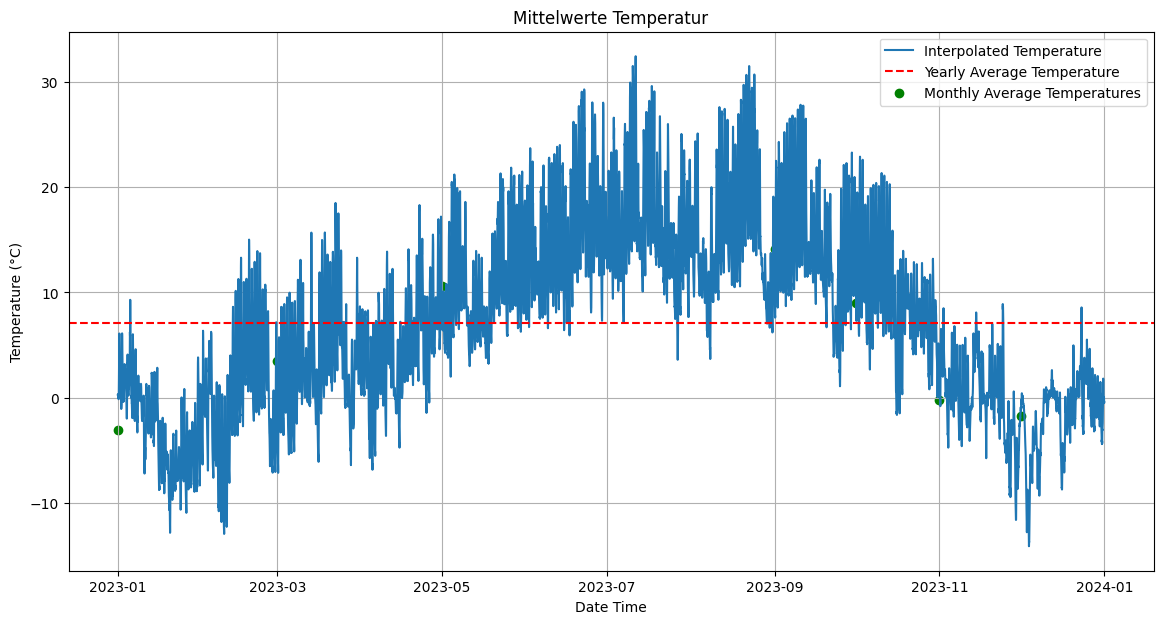

Jährliche Durchschnittstemperatur: 7.129213430956362
Monatliche Durchschnittstemperaturen (von Januar bis Dezember): [-3.0281184522206503, 0.07302599508085625, 3.4664533505504753, 4.8505277309558235, 10.60150284330136, 15.598982642648124, 16.63268598230861, 15.619881752805892, 14.153950787626949, 8.994300916951065, -0.1718435104422553, -1.7631795994485118]


In [93]:
# Calculate the average temperature over the entire year
yearly_avg_temp = simps(interpolated_temps, dx=15*60) / (interpolation_index[-1] - interpolation_index[0]).total_seconds()

# Calculate the average temperature per month
monthly_avg_temps = []
for i in range(12):
    month_start = interpolation_index[0] + pd.DateOffset(months=i)
    month_end = interpolation_index[0] + pd.DateOffset(months=i+1)
    month_mask = (interpolation_index >= month_start) & (interpolation_index < month_end)
    monthly_avg_temp = simps(interpolated_temps[month_mask], dx=15*60) / (month_end - month_start).total_seconds()
    monthly_avg_temps.append(monthly_avg_temp)

# Plotting
plt.figure(figsize=(14, 7), facecolor='white')
plt.plot(interpolation_index, interpolated_temps, label='Interpolated Temperature')
plt.axhline(y=yearly_avg_temp, color='r', linestyle='--', label='Yearly Average Temperature')
monthly_points = [interpolation_index[0] + pd.DateOffset(months=i) for i in range(12)]
plt.scatter(monthly_points, monthly_avg_temps, color='g', label='Monthly Average Temperatures')
plt.title('Mittelwerte Temperatur')
plt.xlabel('Date Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

# Output Durchschnittswerte
print('Jährliche Durchschnittstemperatur:', yearly_avg_temp)
print('Monatliche Durchschnittstemperaturen (von Januar bis Dezember):', monthly_avg_temps)

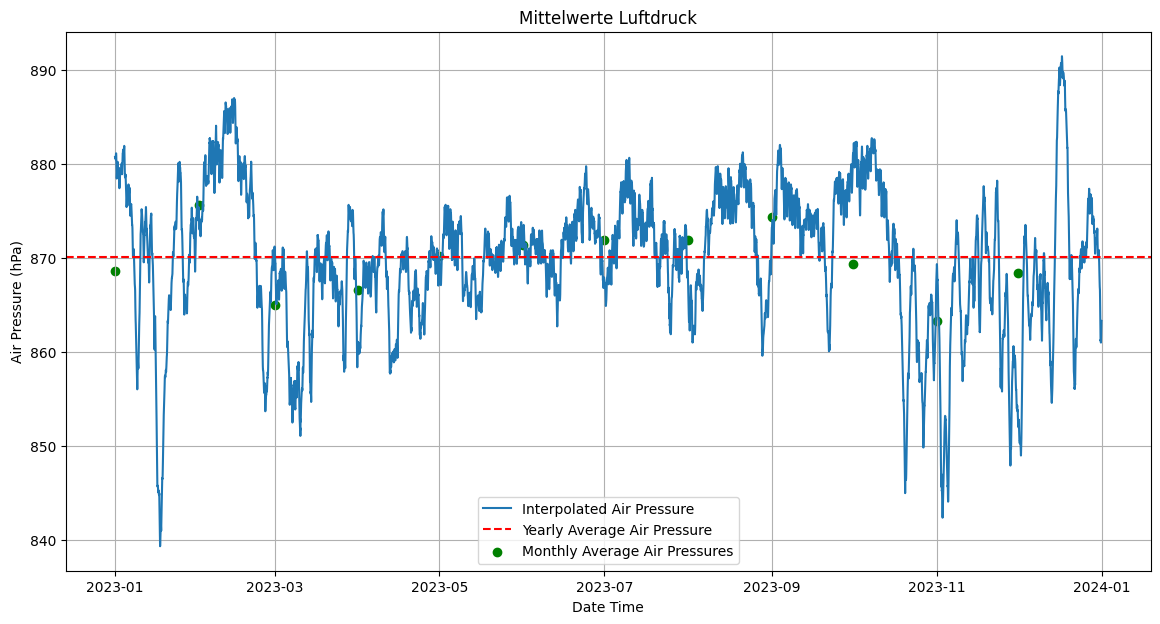

Jährlicher durchschnittlicher Luftdruck: 870.0586246265381
Monatlicher durchschnittlicher Luftdruck (von Januar bis Dezember): [868.6194113086943, 875.6525659894395, 865.020878277341, 866.6065967627236, 870.203228306013, 871.3657955748735, 871.9084154759736, 871.913119335004, 874.3498711046769, 869.3894800452505, 863.2765316857868, 868.4070801956831]


In [94]:
# Calculate the average air pressure over the entire year
yearly_avg_pressure = simps(interpolated_pressures, dx=15*60) / (interpolation_index[-1] - interpolation_index[0]).total_seconds()

# Calculate the average air pressure per month
monthly_avg_pressures = []
for i in range(12):
    month_start = interpolation_index[0] + pd.DateOffset(months=i)
    month_end = interpolation_index[0] + pd.DateOffset(months=i+1)
    month_mask = (interpolation_index >= month_start) & (interpolation_index < month_end)
    monthly_avg_pressure = simps(interpolated_pressures[month_mask], dx=15*60) / (month_end - month_start).total_seconds()
    monthly_avg_pressures.append(monthly_avg_pressure)

# Plotting
plt.figure(figsize=(14, 7), facecolor='white')
plt.plot(interpolation_index, interpolated_pressures, label='Interpolated Air Pressure')
plt.axhline(y=yearly_avg_pressure, color='r', linestyle='--', label='Yearly Average Air Pressure')
monthly_points = [interpolation_index[0] + pd.DateOffset(months=i) for i in range(12)]
plt.scatter(monthly_points, monthly_avg_pressures, color='g', label='Monthly Average Air Pressures')
plt.title('Mittelwerte Luftdruck')
plt.xlabel('Date Time')
plt.ylabel('Air Pressure (hPa)')
plt.legend()
plt.grid(True)
plt.show()

# Output averages
print('Jährlicher durchschnittlicher Luftdruck:', yearly_avg_pressure)
print('Monatlicher durchschnittlicher Luftdruck (von Januar bis Dezember):', monthly_avg_pressures)

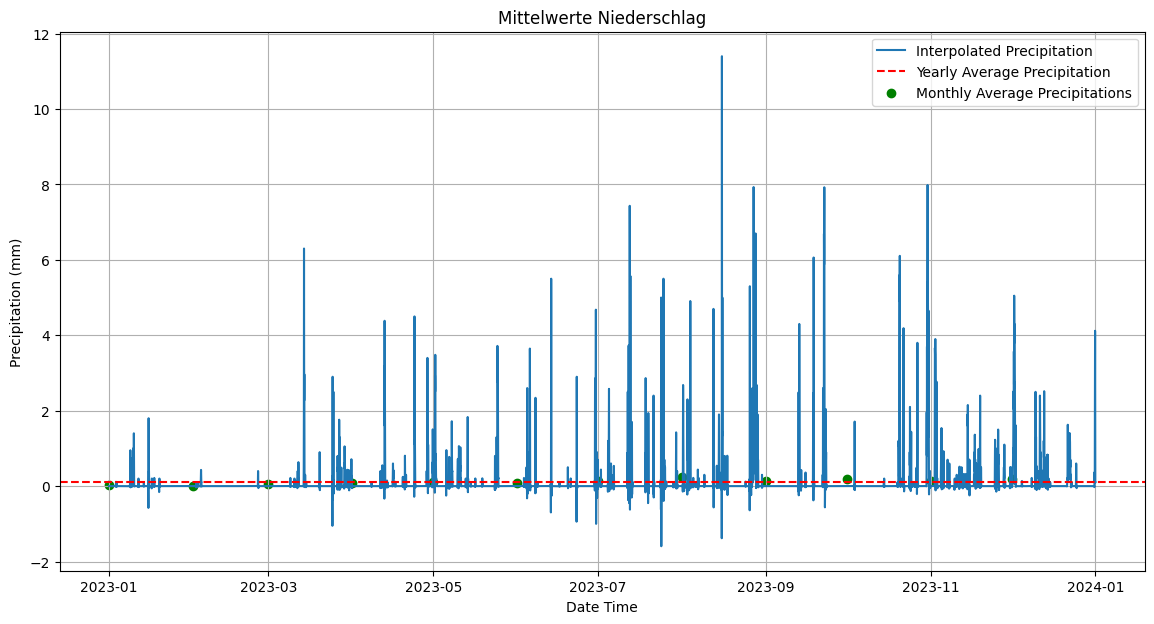

Jährlicher durchschnittlicher Niederschlag: 0.11405713740898911
Monatliche durchschnittliche Niederschläge (von Januar bis Dezember): [0.018603398234077435, 0.004060682912311413, 0.06479201057335658, 0.0779900470835955, 0.10029916340599464, 0.07163287877886201, 0.12710741126471092, 0.2535088759714285, 0.12562798264066066, 0.19860109948386193, 0.13720896051755682, 0.17680841857375718]


In [95]:
# Calculate the average precipitation over the entire year
yearly_avg_precipitation = simps(interpolated_precipitations, dx=15*60) / (interpolation_index[-1] - interpolation_index[0]).total_seconds()

# Calculate the average precipitation per month
monthly_avg_precipitations = []
for i in range(12):
    month_start = interpolation_index[0] + pd.DateOffset(months=i)
    month_end = interpolation_index[0] + pd.DateOffset(months=i+1)
    month_mask = (interpolation_index >= month_start) & (interpolation_index < month_end)
    monthly_avg_precipitation = simps(interpolated_precipitations[month_mask], dx=15*60) / (month_end - month_start).total_seconds()
    monthly_avg_precipitations.append(monthly_avg_precipitation)

# Plotting
plt.figure(figsize=(14, 7), facecolor='white')
plt.plot(interpolation_index, interpolated_precipitations, label='Interpolated Precipitation')
plt.axhline(y=yearly_avg_precipitation, color='r', linestyle='--', label='Yearly Average Precipitation')
monthly_points = [interpolation_index[0] + pd.DateOffset(months=i) for i in range(12)]
plt.scatter(monthly_points, monthly_avg_precipitations, color='g', label='Monthly Average Precipitations')
plt.title('Mittelwerte Niederschlag')
plt.xlabel('Date Time')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True)
plt.show()

# Output averages
print('Jährlicher durchschnittlicher Niederschlag:', yearly_avg_precipitation)
print('Monatliche durchschnittliche Niederschläge (von Januar bis Dezember):', monthly_avg_precipitations)

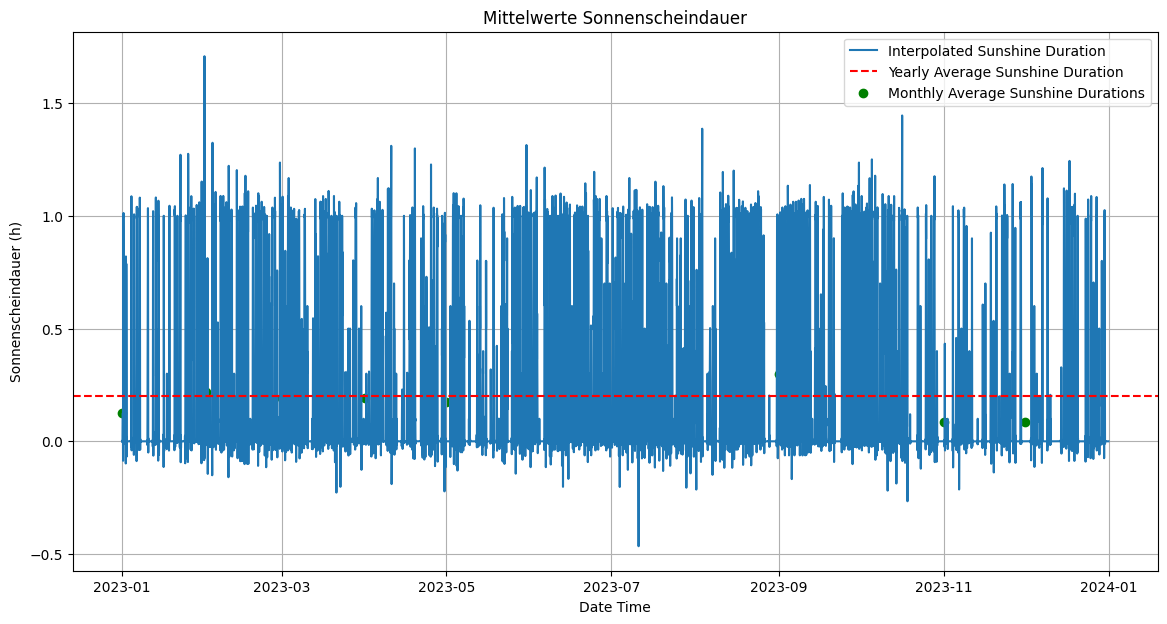

Jährliche durchschnittliche Sonnenscheindauer: 0.19914178261220664
Monatliche durchschnittliche Sonnenscheindauer (von Januar bis Dezember): [0.1256852492814741, 0.22005697253377385, 0.18988106570667046, 0.1920302021086866, 0.1761134068842416, 0.3107786823717131, 0.28886097637790237, 0.23595691962713444, 0.30031241205174236, 0.1857471841007927, 0.0835423312401453, 0.08538012399007285]


In [96]:
# Calculate the average sunshine duration over the entire year
yearly_avg_sunshine_duration = simps(interpolated_sunshine_durations, dx=15*60) / (interpolation_index[-1] - interpolation_index[0]).total_seconds()

# Calculate the average sunshine duration per month
monthly_avg_sunshine_durations = []
for i in range(12):
    month_start = interpolation_index[0] + pd.DateOffset(months=i)
    month_end = interpolation_index[0] + pd.DateOffset(months=i+1)
    month_mask = (interpolation_index >= month_start) & (interpolation_index < month_end)
    monthly_avg_sunshine_duration = simps(interpolated_sunshine_durations[month_mask], dx=15*60) / (month_end - month_start).total_seconds()
    monthly_avg_sunshine_durations.append(monthly_avg_sunshine_duration)

# Plotting
plt.figure(figsize=(14, 7), facecolor='white')
plt.plot(interpolation_index, interpolated_sunshine_durations, label='Interpolated Sunshine Duration')
plt.axhline(y=yearly_avg_sunshine_duration, color='r', linestyle='--', label='Yearly Average Sunshine Duration')
monthly_points = [interpolation_index[0] + pd.DateOffset(months=i) for i in range(12)]
plt.scatter(monthly_points, monthly_avg_sunshine_durations, color='g', label='Monthly Average Sunshine Durations')
plt.title('Mittelwerte Sonnenscheindauer')
plt.xlabel('Date Time')
plt.ylabel('Sonnenscheindauer (h)')
plt.legend()
plt.grid(True)
plt.show()

# Output averages
print('Jährliche durchschnittliche Sonnenscheindauer:', yearly_avg_sunshine_duration)
print('Monatliche durchschnittliche Sonnenscheindauer (von Januar bis Dezember):', monthly_avg_sunshine_durations)

### 7. Glättung (Gleitendes Mittel) bestimmen

Nehmt die gleiche Messgrösse wie in Schritt 6 und berechnet das gleitende Mittel über das ganze Jahr. Dazu soll die Faltung mit einer symmetrischen Rechteckfunktion verwendet werden. Die Fensterbreite (Breite des Rechtecks) soll ein Parameter sein, den ihr variieren könnt.

Stellt die Messgrösse und das gleitende Mittel mit Fensterbreite = 1 Woche zusammen dar. Optional könnt ihr dazu auch noch das gleitende Mittel mit Fensterbreite = 1 Monat darstellen.

*Vorsicht:* Die Faltung ist rechenintensiv. Berechnet also zuerst das gleitende Mittel an wenigen Zeitpunkten über das ganze Jahr, z.B. 100, und erhöht dann die Anzahl Zeitpunkte vorsichtig.

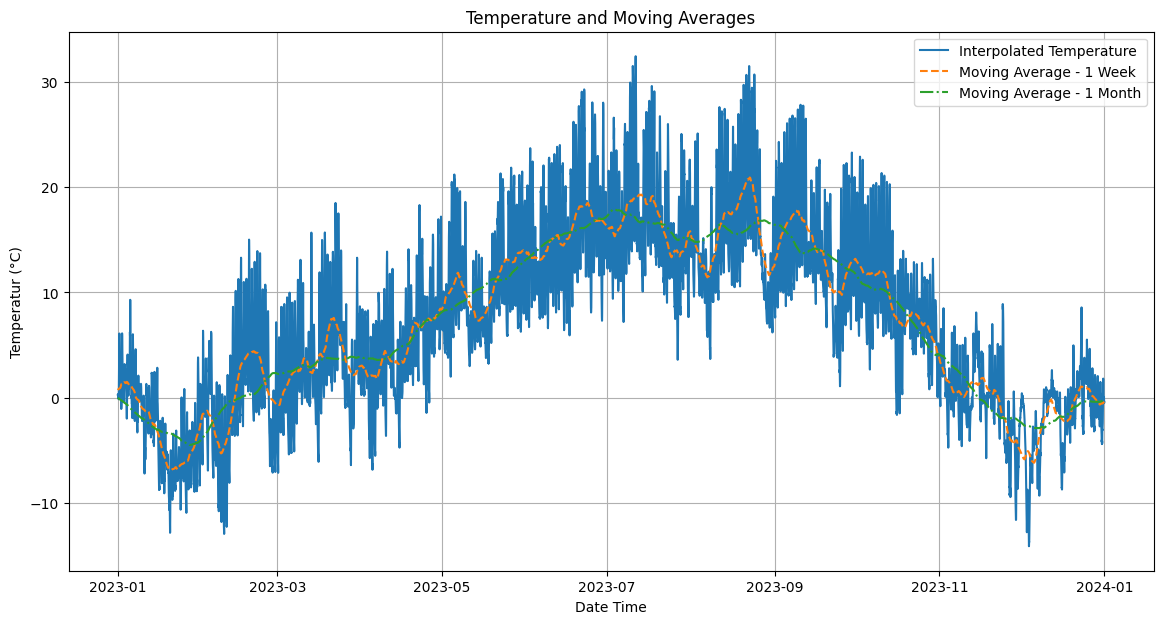

In [99]:
# Define the rectangle function for convolution
week_window = np.ones(int(7*24*4)) / (7*24*4)  # 7 days, 24 hours per day, 4 quarters per hour
month_window = np.ones(int(30*24*4)) / (30*24*4)  # 30 days, 24 hours per day, 4 quarters per hour

# Calculate moving averages using convolution
moving_avg_week = convolve(interpolated_temps, week_window, mode='same')
moving_avg_month = convolve(interpolated_temps, month_window, mode='same')

# Plotting
plt.figure(figsize=(14, 7), facecolor='white')
plt.plot(interpolation_index, interpolated_temps, label='Interpolated Temperature')
plt.plot(interpolation_index, moving_avg_week, label='Moving Average - 1 Week', linestyle='--')
plt.plot(interpolation_index, moving_avg_month, label='Moving Average - 1 Month', linestyle='-.')
plt.title('Temperature and Moving Averages')
plt.xlabel('Date Time')
plt.ylabel('Temperatur (°C)')
plt.legend()
plt.grid(True)
plt.show()

### Zusammenfassung

### Reflexion

Mitglied 1: Melanie Rohrbacher
- Was hat gut funktioniert?
    - Aufgabenverteilung und Kommunikation zueinander (für die ersten paar Wochen)

- Was hat nicht gut funktioniert?
    - Der Kampf, die Grafik so darzustellen, wie ich es im Kopf haben wollte
    - Den Überblick bei all den Daten zu behalten, nach jeder Arbeitssitzung ist es oft notwendig, sich erneut zu informieren und weiter zu recherchieren.
    - Mehrmals die Strategie oder Bibliothek geändert um es "besser" darzustellen
    - Mehrere Projektfiles erstellt und dann denn Überblick verloren welches das richtige File war mit den "richtigen" Daten.

- Was würdest du beim nächsten Mal anders machen?
    - Mehr Zeit für die Aufgaben einplanen 
    - Organisierter vorangehen: die Arbeitsschritte / Diagram zufrieden abschliessen, bevor man ein neues kreiert. 

- Was hast du gelernt?
    - Dass Python ein mächtiges Tool ist, welches ich nie vollständig beherrschen werde
    - Generell alle Themen des Moduls sind mir neu (ausserhalb des Unterrichts noch nie was von Interpolation gehört)
    - Verküpfte Arbeitsweise zwischen dem Aufgabenmaterial im Unterricht und besseres prompting ChatGPT
    - ChatGPT und andere KI-Tools werden zukünftig diese Arbeit vollständig übernehmen, doch bis jetzt ist es noch nicht so ausgereift und fehlerhaft
    

- Was war die grösste Herausforderung?
    - Die Sache irgendwie allein durchzuboxen 
    - Durchhaltevermögen beim Debuggen. (Zerrt an den Nerven.)
    - Überblick zu bewahren 

- usw.
    - Wenn es darum geht, etwas selbst zu kreieren, sei es im Bereich Kunst, Musik oder Programmierung, muss man irgendwann selbst den Schlussstrich ziehen und die Sache beenden, obwohl man die eigene Arbeit noch besser, einfacher oder schöner darstellen könnte...
